In [7]:
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
import multiprocessing
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer  
from skopt.utils import use_named_args
import pickle
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow
from tensorflow.python.keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import Adam
import numpy as np
import json

In [8]:
BIDS_path = 'C:\\Users\\ICN_admin\\Documents\\BIDS\\'
subject_id = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
out_path = 'C:\\Users\\ICN_admin\\Documents\\Ubuntu_SAVE\\Documents\\raw_out\\LM_100ms\\'

### Concatenate different time point points 

In [9]:
def append_time_dim(arr, y_, time_stamps):
    """
    apply added time dimension for the data array and label given time_stamps
    """
    time_arr = np.zeros([arr.shape[0]-time_stamps, int(time_stamps*arr.shape[1])])
    for time_idx, time_ in enumerate(np.arange(time_stamps, arr.shape[0])):
        for time_point in range(time_stamps):
            time_arr[time_idx, time_point*arr.shape[1]:(time_point+1)*arr.shape[1]] = arr[time_-time_point,:]
    return time_arr, y_[time_stamps:]

### Keras method to build up NN architecture

In [10]:
def create_model_NN():
    #start the model making process and create our first layer
    model = Sequential()
    model.add(Dense(num_input_nodes, input_shape=(40,), activation=activation
                   ))
    #create a loop making a new dense layer for the amount passed to this model.
    #naming the layers helps avoid tensorflow error deep in the stack trace.
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes,
                 activation=activation,
                        name=name
                 ))
    #add our classification layer.
    model.add(Dense(1,activation='linear'))
    
    #setup our optimizer and compile
    adam = Adam(lr=learning_rate)
    model.compile(optimizer=adam, loss='mean_squared_error',
                 metrics=['mse'])
    return model

### defining hyperparameter search space and objective for NN

In [11]:
# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the learning rate)

space_NN = [Real(low=1e-4, high=1e-2, prior='log-uniform', name='learning_rate'),
              Integer(low=1, high=3, name='num_dense_layers'),
              Integer(low=1, high=10, prior='uniform', name='num_input_nodes'),
              Integer(low=1, high=10, name='num_dense_nodes'),
              Categorical(categories=['relu', 'tanh'], name='activation')
             ]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space_NN)
def objective_NN(**params):
    print(params)

    global learning_rate
    learning_rate=params["learning_rate"]
    global num_dense_layers
    num_dense_layers=params["num_dense_layers"]
    global num_input_nodes
    num_input_nodes=params["num_input_nodes"]
    global num_dense_nodes
    num_dense_nodes=params["num_dense_nodes"]
    global activation
    activation=params["activation"]
    
    
    
    model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=1000, verbose=0)
    
    
    X_train, X_test, y_train, y_test = train_test_split(X_time, y_time, test_size=0.33, random_state=42)
    
    model.fit(X_train, y_train)
    
    y_pr = model.predict(X_test)
    
    res = metrics.r2_score(y_test, y_pr)
    
    if res < 0:
        res = 0
    
    
    #cv_res = cross_val_score(model, X_time, y_time, cv=1, n_jobs=1, scoring="r2")
    
    #kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    
    #cv_res = cross_val_score(reg, X_time, y_time, cv=3, n_jobs=-1,
    #                                scoring="r2")
    #cv_res[np.where(cv_res < 0)[0]] = 0
    return -res
    #return -cv_result['test-r2-mean'].iloc[-1]

### same for LM (here elastic net sklearn regularization)

In [12]:
space_LM = [Real(0, 1, "uniform", name='alpha'),
           Real(0, 1, "uniform", name='l1_ratio'), 
           Integer(1000, 5000, name='max_iter')]

@use_named_args(space_LM)
def objective_LM(**params):
    print(params)
    
    params_ = {'alpha': params["alpha"],
         'l1_ratio': params['l1_ratio'],
         'max_iter': params["max_iter"]}
    
    reg.set_params(**params_)
    cv_res = cross_val_score(reg, X_time, y_time, cv=3, n_jobs=59, scoring="r2")
    
    
    #cv_res = cross_val_score(reg, X_time, y_time, cv=3, n_jobs=-1,
    #                                scoring="r2")
    cv_res[np.where(cv_res < 0)[0]] = 0
    return -np.mean(cv_res)

### XGB regressor 

In [13]:
space_XGB  = [Integer(1, 100, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(10**0, 10**3, "log-uniform", name='n_estimators'), 
          Real(10**0, 10**1, "uniform", name="gamma")]

# necessary since XGB does not support r^2, so I use the sklean one instead
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    # return a pair metric_name, result. The metric name must not contain a
    # colon (:) or a space since preds are margin(before logistic
    # transformation, cutoff at 0)
    
    r2 = metrics.r2_score(labels, preds)
    
    if r2 < 0:
        r2 = 0
    
    return 'r2', r2

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space_XGB)
def objective_XGB(**params):
    print(params)
    
    params_ = {'max_depth': int(params["max_depth"]),
         'gamma': params['gamma'],
         'n_estimators': int(params["n_estimators"]),
         'learning_rate': params["learning_rate"],
         'subsample': 0.8,
         'eta': 0.1,
         'disable_default_eval_metric' : 1} 
         #'tree_method' : 'gpu_hist', 
        #'gpu_id' : 1}
    
    cv_result = xgb.cv(params_, dtrain, num_boost_round=30, feval=evalerror, nfold=3)
    
    #reg.set_params(**params)
    #cv_res = cross_val_score(reg, X_time, y_time, cv=3, n_jobs=-1,
    #                                scoring="r2")
    #cv_res[np.where(cv_res < 0)[0]] = 0
    #return -np.mean(cv_res)
    return -cv_result['test-r2-mean'].iloc[-1]

In [ ]:
### run analysis (here only for LM) through the BIDS dataset 

In [15]:
for subject in subject_id:
    with open('dat\\sub_'+subject+'_patient_concat.json') as f:
        data = json.load(f)
        channels = list(data.keys())

        d_out = {}

        for ch in channels:
            X = np.array(data[ch]['data']).T
            y_ = np.array(data[ch]['true_movements'])
            mov_ch = data[ch]['mov_ch']

            d_out[ch] = {}

            for y_idx in range(y_.shape[0]):
                print('subject: '+str(subject)+' channel: '+str(ch)+' mov: '+str(mov_ch[y_idx]))
                y = y_[y_idx,:]
                
                X_time, y_time = append_time_dim(X, y, 5)
                
                reg = ElasticNet()
                res_gp = gp_minimize(objective_LM, space_LM, n_calls=10, random_state=0)
                
                d_out[ch][mov_ch[y_idx]] = res_gp
    with open('lmelasticnet_sub_'+subject+'.p', 'wb') as handle:
        pickle.dump(d_out, handle, protocol=pickle.HIGHEST_PROTOCOL)
        

subject: 000 channel: ECOG_RIGHT_0 mov: MOV_RIGHT
{'alpha': 0.5928446182250184, 'l1_ratio': 0.8442657485810175, 'max_iter': 4432}
{'alpha': 0.8472517387841256, 'l1_ratio': 0.6235636967859725, 'max_iter': 2538}
{'alpha': 0.29753460654447234, 'l1_ratio': 0.056712977317443194, 'max_iter': 2091}
{'alpha': 0.47766511732135, 'l1_ratio': 0.8121687287754934, 'max_iter': 2920}
{'alpha': 0.39278479610082984, 'l1_ratio': 0.8360787635373778, 'max_iter': 2350}
{'alpha': 0.6481718720511973, 'l1_ratio': 0.368241539840548, 'max_iter': 4829}
{'alpha': 0.14035078041264518, 'l1_ratio': 0.8700872583584366, 'max_iter': 2894}
{'alpha': 0.8009107519796445, 'l1_ratio': 0.5204774795512049, 'max_iter': 3716}
{'alpha': 0.7206326547259169, 'l1_ratio': 0.5820197920751072, 'max_iter': 3149}
{'alpha': 0.7586156243223574, 'l1_ratio': 0.10590760718779216, 'max_iter': 2894}
subject: 000 channel: ECOG_RIGHT_0 mov: MOV_LEFT
{'alpha': 0.5928446182250184, 'l1_ratio': 0.8442657485810175, 'max_iter': 4432}
{'alpha': 0.847251

KeyboardInterrupt: 

### check convergence plot 

In [18]:
from skopt.plots import plot_convergence
%matplotlib inline

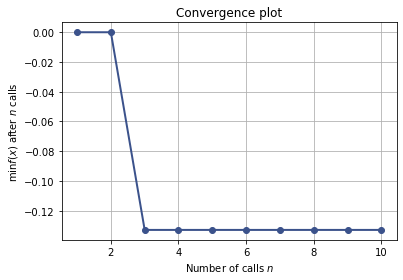

In [19]:
plot_convergence(res_gp)